# Job postings data exploration

Data exploration and analysis of job offers posted on [No Fluff Jobs](https://nofluffjobs.com/pl). Data is obtained either by API (preferred) or web scraping.

## Setup

In [1]:
import functools
from typing import Any
import time

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from plotly import express as px
from plotly import graph_objects as go
from retry import retry
from sklearn import preprocessing

To enable static rendering of this notebook (e.g. for GitHub) the default graph rendered is set to `'png'`. If you want to use the notebook in an interactive way disable the cell below.

In [2]:
import plotly.io as pio
pio.renderers.default='png'

## Data ingestion

We are going to get the job postings data through the No Fluff Jobs web API. The API can be explored by using web inspector on a sample posting page. For example, in Safari network monitoring is available under *Network* and *XHR*. We are looking for a request called `posting`.

After investigating the requests made by the web page we can infer that there is a `GET` endpoint at `https://nofluffjobs.com/api/posting`. We can copy the request and make analogous API calls from curl or any programming langauge. Let's use Python's `requests` to obtain the data for further invesigation.

> ❗️ Please don't abuse this endpoint and don't overload it with too many queries

In [3]:
r = requests.get('https://nofluffjobs.com/api/posting')
j = r.json()

Now we have the json as a dict, let's examine its keys.

In [4]:
j.keys()

dict_keys(['postings', 'totalCount', 'pageUniqueCount', 'totalUniqueCount', 'overridenSalaryFilter'])

In [5]:
for k in j.keys():
    print(k, type(j[k]))

postings <class 'list'>
totalCount <class 'int'>
pageUniqueCount <class 'int'>
totalUniqueCount <class 'int'>
overridenSalaryFilter <class 'dict'>


In [6]:
f"{j['totalCount']=}, {j['totalUniqueCount']=}, {j['overridenSalaryFilter']=}"

"j['totalCount']=14451, j['totalUniqueCount']=2295, j['overridenSalaryFilter']={}"

We have several metadata fields and the `postings` key holds the actual job offers list. This list's length should be same as `totalCount`.

In [7]:
postings = j['postings']

In [8]:
assert len(postings) == j['totalCount'] 
len(postings)

14451

## Raw data exploration

### Exploring the JSON obtained from the API

Let's examine first offer in the list.

In [9]:
postings[0].keys()

dict_keys(['id', 'name', 'location', 'posted', 'renewed', 'title', 'technology', 'logo', 'category', 'seniority', 'url', 'regions', 'fullyRemote', 'salary', 'flavors', 'topInSearch', 'highlighted', 'help4Ua', 'searchBoost', 'onlineInterviewAvailable', 'tiles'])

In [10]:
postings[0]

{'id': 'mid-senior-data-engineer-getindata-part-of-xebia-Remote-1',
 'name': 'GetInData | Part of Xebia',
 'location': {'places': [{'city': 'Remote',
    'url': 'mid-senior-data-engineer-getindata-part-of-xebia-remote-1'},
   {'country': {'code': 'POL', 'name': 'Poland'},
    'city': 'Warsaw',
    'street': 'ul. Puławska 39/20',
    'postalCode': '02-508',
    'geoLocation': {'latitude': 52.2073309, 'longitude': 21.0225809},
    'url': 'mid-senior-data-engineer-getindata-part-of-xebia-warsaw-1'},
   {'country': {'code': 'POL', 'name': 'Poland'},
    'province': 'lower-silesian',
    'url': 'mid-senior-data-engineer-getindata-part-of-xebia-lower-silesian-1',
    'provinceOnly': True},
   {'country': {'code': 'POL', 'name': 'Poland'},
    'province': 'kuyavian-pomeranian',
    'url': 'mid-senior-data-engineer-getindata-part-of-xebia-kuyavian-pomeranian-1',
    'provinceOnly': True},
   {'country': {'code': 'POL', 'name': 'Poland'},
    'province': 'lodz',
    'url': 'mid-senior-data-engi

The most interesting keys for analysis and predictions seem to be `location`, `technology`, `category`, `seniority`, and `salary`. Difference between current time and `posted` may be useful for general analysis (how long a posting is active); same with `fullyRemote` (would be nice to have a pie chart of _remote_ vs _office_). Company `name`, job `title`, and `regions` won't be useful for analysis but provide some extra information. `id` and `url` may be useful for further processing. Keys like `renewed`, `logo`, `flavors`, `topInSearch`, `highlighted`, and `onlineInterviewAvailable` are neither interesting nor relevant for the analysis.

### Scrapping the missing information

However, the actual posting pages contain much more information than the API provides. Seems that some information is server-site generated. In this case we have to scrap it. After exploring the postings addresses and the JSON data it can be seen that the posting's html page is under `https://nofluffjobs.com/pl/job/` + `url` inside the JSON (and the url itself is combination of some other keys like `title` and `id`).

In [11]:
html_posting = requests.get('https://nofluffjobs.com/pl/job/' + postings[0]['url'])

In [12]:
soup = BeautifulSoup(html_posting.content, 'html.parser')

For now, we will proceed with using the JSON data obtained from API, but soup can also be used to get postings insights from directly from the website.



## Preliminary statistics and data cleaning

Let's look at the data we have. We will use pandas for data analysis.

In [13]:
df = pd.DataFrame.from_dict(postings)

In [14]:
df.columns

Index(['id', 'name', 'location', 'posted', 'renewed', 'title', 'technology',
       'logo', 'category', 'seniority', 'url', 'regions', 'fullyRemote',
       'salary', 'flavors', 'topInSearch', 'highlighted', 'help4Ua',
       'searchBoost', 'onlineInterviewAvailable', 'tiles', 'referralBonus',
       'referralBonusCurrency'],
      dtype='object')

In [15]:
df.head(3)

,id,name,location,posted,renewed,title,technology,logo,category,seniority,...,salary,flavors,topInSearch,highlighted,help4Ua,searchBoost,onlineInterviewAvailable,tiles,referralBonus,referralBonusCurrency
0,mid-senior-data-engineer-getindata-part-of-xeb...,GetInData | Part of Xebia,"{'places': [{'city': 'Remote', 'url': 'mid-sen...",1734091309392,1.734523e+12,Mid/Senior Data Engineer,Hadoop,{'original': 'companies/logos/original/grafika...,data,[Senior],...,"{'from': 23520.0, 'to': 31080.0, 'type': 'b2b'...",[it],False,False,True,True,True,"{'values': [{'value': 'data', 'type': 'categor...",NaN,NaN
1,mid-senior-data-engineer-getindata-part-of-xeb...,GetInData | Part of Xebia,"{'places': [{'country': {'code': 'POL', 'name'...",1734091309392,1.734523e+12,Mid/Senior Data Engineer,Hadoop,{'original': 'companies/logos/original/grafika...,data,[Senior],...,"{'from': 23520.0, 'to': 31080.0, 'type': 'b2b'...",[it],False,False,True,True,True,"{'values': [{'value': 'data', 'type': 'categor...",NaN,NaN
2,mid-senior-data-engineer-getindata-part-of-xeb...,GetInData | Part of Xebia,"{'places': [{'country': {'code': 'POL', 'name'...",1734091309392,1.734523e+12,Mid/Senior Data Engineer,Hadoop,{'original': 'companies/logos/original/grafika...,data,[Senior],...,"{'from': 23520.0, 'to': 31080.0, 'type': 'b2b'...",[it],False,False,True,True,True,"{'values': [{'value': 'data', 'type': 'categor...",NaN,NaN


For some reason the entries seem duplicated. The `name`, `posted`, `title`, and other fileds look indentical. Let's take a closer look at IDs of the duplicates.

In [16]:
list(df['id'].head(20))

['mid-senior-data-engineer-getindata-part-of-xebia-Remote-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-Warsaw-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-lower-silesian-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-kuyavian-pomeranian-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-lodz-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-lublin-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-lubusz-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-lesser-poland-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-opole-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-subcarpathian-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-podlaskie-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-pomeranian-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-silesian-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-holy-cross-1',
 'mid-senior-data-engineer-getindata-part-of-xebia-warmian-masurian-1',
 'mid-senior-da

Seems that there are duplicate entires based on different locations for the same posting. However, the `location` field for each posting is a list of locations itself. Let's compare the duplicate IDs against the list of locations for the very first entry.

In [17]:
df.iloc[1]['location']

{'places': [{'country': {'code': 'POL', 'name': 'Poland'},
   'city': 'Warsaw',
   'street': 'ul. Puławska 39/20',
   'postalCode': '02-508',
   'geoLocation': {'latitude': 52.2073309, 'longitude': 21.0225809},
   'url': 'mid-senior-data-engineer-getindata-part-of-xebia-warsaw-1'},
  {'city': 'Remote',
   'url': 'mid-senior-data-engineer-getindata-part-of-xebia-remote-1'},
  {'country': {'code': 'POL', 'name': 'Poland'},
   'province': 'lower-silesian',
   'url': 'mid-senior-data-engineer-getindata-part-of-xebia-lower-silesian-1',
   'provinceOnly': True},
  {'country': {'code': 'POL', 'name': 'Poland'},
   'province': 'kuyavian-pomeranian',
   'url': 'mid-senior-data-engineer-getindata-part-of-xebia-kuyavian-pomeranian-1',
   'provinceOnly': True},
  {'country': {'code': 'POL', 'name': 'Poland'},
   'province': 'lodz',
   'url': 'mid-senior-data-engineer-getindata-part-of-xebia-lodz-1',
   'provinceOnly': True},
  {'country': {'code': 'POL', 'name': 'Poland'},
   'province': 'lublin',

Besides the list of provinces, there is a subfiled with actual city location under `places`.

In [18]:
df.iloc[1]['location']['places'][0]

{'country': {'code': 'POL', 'name': 'Poland'},
 'city': 'Warsaw',
 'street': 'ul. Puławska 39/20',
 'postalCode': '02-508',
 'geoLocation': {'latitude': 52.2073309, 'longitude': 21.0225809},
 'url': 'mid-senior-data-engineer-getindata-part-of-xebia-warsaw-1'}

The locations in the list seem similar to the duplicate ID entries. Let's check if the location list for duplicate entries are identical for first ten entries.

In [19]:
all(
    df.groupby(['name', 'posted', 'title'])['location'].transform(
        lambda locations: all(locations.iloc[0]['places'] == entry['places'] for entry in locations)
    )
)

False

It seems that they are different, however, let's double check and sort the locations berfore comparing them.

In [20]:
def sort_places(row: pd.core.series.Series, by='url') -> list:
    return sorted(row['places'], key=lambda place: place[by])

In [21]:
all(
    df.groupby(['name', 'posted', 'title'])['location'].transform(
        lambda locations: all(
            sort_places(locations.iloc[0]) == sort_places(entry) for entry in locations
        )
    )
)

True

Fortunately, the duplicates have identical locations after sorting, now we can drop them based on name, posted date, and title.

In [22]:
df = df.drop_duplicates(subset=['name', 'posted', 'title'])
len(df)

2295

At last, we can check whether the postings list after duplicates has the same lenght as total unique count in the metadata.

In [23]:
assert len(df) == j['totalUniqueCount']

## Data processing

After dealing with the duplicates, we can print the unique data and decide which data fields are useful for us.

In [24]:
df.columns

Index(['id', 'name', 'location', 'posted', 'renewed', 'title', 'technology',
       'logo', 'category', 'seniority', 'url', 'regions', 'fullyRemote',
       'salary', 'flavors', 'topInSearch', 'highlighted', 'help4Ua',
       'searchBoost', 'onlineInterviewAvailable', 'tiles', 'referralBonus',
       'referralBonusCurrency'],
      dtype='object')

In [25]:
df.head(3)

,id,name,location,posted,renewed,title,technology,logo,category,seniority,...,salary,flavors,topInSearch,highlighted,help4Ua,searchBoost,onlineInterviewAvailable,tiles,referralBonus,referralBonusCurrency
0,mid-senior-data-engineer-getindata-part-of-xeb...,GetInData | Part of Xebia,"{'places': [{'city': 'Remote', 'url': 'mid-sen...",1734091309392,1.734523e+12,Mid/Senior Data Engineer,Hadoop,{'original': 'companies/logos/original/grafika...,data,[Senior],...,"{'from': 23520.0, 'to': 31080.0, 'type': 'b2b'...",[it],False,False,True,True,True,"{'values': [{'value': 'data', 'type': 'categor...",NaN,NaN
17,ux-product-designer-qurate-retail-group-global...,QURATE RETAIL GROUP GLOBAL BUSINESS SERVICES,"{'places': [{'city': 'Remote', 'url': 'ux-prod...",1733151200851,1.734966e+12,UX Product Designer,NaN,{'original': 'companies/logos/original/zrzut_e...,ux,[Mid],...,"{'from': 11000.0, 'to': 15000.0, 'type': 'perm...",[it],False,True,False,True,True,"{'values': [{'value': 'ux', 'type': 'category'...",NaN,NaN
34,ux-designer-emagine-Warszawa-1,emagine Sp. Z o.o.,"{'places': [{'country': {'code': 'POL', 'name'...",1732104615820,1.734437e+12,UX Designer,NaN,{'original': 'companies/logos/original/pl_emag...,ux,[Mid],...,"{'from': 26040.0, 'to': 26040.0, 'type': 'b2b'...",[it],False,True,True,False,False,"{'values': [{'value': 'ux', 'type': 'category'...",NaN,NaN


The table is rather messy, some columns should be dropped. After that we can reexamine the data.

In [26]:
df = df[['id', 'name', 'location', 'posted', 'title', 'technology', 'category', 'seniority', 'fullyRemote', 'salary']]

In [27]:
df.head(3)

,id,name,location,posted,title,technology,category,seniority,fullyRemote,salary
0,mid-senior-data-engineer-getindata-part-of-xeb...,GetInData | Part of Xebia,"{'places': [{'city': 'Remote', 'url': 'mid-sen...",1734091309392,Mid/Senior Data Engineer,Hadoop,data,[Senior],False,"{'from': 23520.0, 'to': 31080.0, 'type': 'b2b'..."
17,ux-product-designer-qurate-retail-group-global...,QURATE RETAIL GROUP GLOBAL BUSINESS SERVICES,"{'places': [{'city': 'Remote', 'url': 'ux-prod...",1733151200851,UX Product Designer,NaN,ux,[Mid],False,"{'from': 11000.0, 'to': 15000.0, 'type': 'perm..."
34,ux-designer-emagine-Warszawa-1,emagine Sp. Z o.o.,"{'places': [{'country': {'code': 'POL', 'name'...",1732104615820,UX Designer,NaN,ux,[Mid],False,"{'from': 26040.0, 'to': 26040.0, 'type': 'b2b'..."


Some rows may be dropped (e.g. with empty values), but we will leave them for now. They can be of some utility or not depending on the future use case.

### Missing values

Let's check which values are missing. Remember that some columns hold compound data structures (e.g. lists or dicts) Missing information in these will not be counted for now.

In [28]:
df.isnull().sum()

id                0
name              0
location          0
posted            0
title             0
technology     1349
category          0
seniority         0
fullyRemote       0
salary            0
dtype: int64

### Values exploration and cleaning

Let's walk through each of the columns that we have at hand, explore them, and transform if needed.

#### Job technologies

Let's explore some column values. We will start with the `technology` column.

In [29]:
df['technology'].unique()

array(['Hadoop', nan, 'PHP', 'JavaScript', 'Python', 'Vue.js', 'Java',
       '.NET', 'SQL', 'Mainframe', 'Node.js', 'Android', 'Golang',
       'Angular', 'React', 'C', 'Ansible', 'iOS', 'C++', 'JIRA', 'Other',
       'Oracle', 'Kotlin', 'TypeScript', '', 'Microsoft Azure',
       'Ruby on Rails', 'React native', 'web', 'Azure', 'IAM',
       'Google Cloud Platform', 'C#', 'Terraform', 'Delphi', 'AWS',
       'Node', 'Elixir', 'UNITY', 'Backup', 'CI/CD', 'Rust', 'MS Azure',
       'Google Cloud', 'Vanilla JS', 'Flutter', 'Selenium', 'CANoe',
       'Hurtownie danych', 'Jenkins', 'MS SQL Server', 'Tableau', 'GCP',
       'Scala', 'Haskell', 'HTML', 'WordPress', 'Data',
       'Kotlin Multiplatform', 'Linux', '.NET Maui', 'Apex', 'Spark',
       'Django', 'Postman', 'Playwright', 'Devops', 'Databricks', 'IBM',
       'ESB / IBM Integration Bus', 'Tibco', 'NestJS', 'Vue 3', 'VMware',
       'Okta', 'Squish', 'AEM', 'LAN/WAN', 'Testing manual', 'Cloud',
       'Appium', 'kubernetes', 'ITI

In [30]:
df['technology'].value_counts().sort_values(ascending=False).head(30)

Java             189
Python           149
.NET              81
React             58
JavaScript        40
PHP               39
C++               28
Angular           26
AWS               26
Node.js           25
Azure             25
                  22
SQL               22
iOS               18
Golang            15
Android           14
Scala             12
Selenium          10
Vue.js             9
TypeScript         7
Spark              7
Ruby on Rails      6
QA                 6
C#                 6
React native       5
Flutter            5
Ansible            5
C                  5
Linux              4
UNITY              4
Name: technology, dtype: int64

Some names seem questionable. Columns `node` and `node.js` should be merged. JavaScript frameworks also kind of double the language as a whole.

In [31]:
df['technology'] = df['technology'].str.lower()

In [32]:
df = df.replace('node.js', 'node')
df = df.replace('angular', 'javascript')
df = df.replace('react', 'javascript')

#### Job categories

In [33]:
df['category'].value_counts().sort_values(ascending=False)

backend                   329
sales                     210
fullstack                 174
data                      131
testing                   130
marketing                 121
devops                    118
frontend                   93
finance                    89
projectManager             74
businessAnalyst            73
customerService            72
mechanics                  65
hr                         54
support                    49
erp                        48
logistics                  46
mobile                     44
security                   43
officeAdministration       42
sysAdministrator           39
electricalEng              37
architecture               30
automation                 29
artificialIntelligence     26
ux                         24
productManagement          22
embedded                   15
businessIntelligence       13
other                      11
electronics                10
consulting                  8
gameDev                     7
agile     

The categories in the `category` column seem fine as they are.

#### Seniority

In [34]:
print(df['seniority'].value_counts())

[Mid]        1058
[Senior]      873
[Junior]      258
[Expert]       68
[Trainee]      38
Name: seniority, dtype: int64


#### Location

In [35]:
df.iloc[1]['location']

{'places': [{'city': 'Remote',
   'url': 'ux-product-designer-qurate-retail-group-global-business-services-remote-1'},
  {'country': {'code': 'POL', 'name': 'Poland'},
   'city': 'Krakow',
   'street': 'Wielicka 30',
   'postalCode': '31-552',
   'geoLocation': {'latitude': 50.0392479, 'longitude': 19.9652207},
   'url': 'ux-product-designer-qurate-retail-group-global-business-services-krakow-1'},
  {'country': {'code': 'POL', 'name': 'Poland'},
   'province': 'lower-silesian',
   'url': 'ux-product-designer-qurate-retail-group-global-business-services-lower-silesian-1',
   'provinceOnly': True},
  {'country': {'code': 'POL', 'name': 'Poland'},
   'province': 'kuyavian-pomeranian',
   'url': 'ux-product-designer-qurate-retail-group-global-business-services-kuyavian-pomeranian-1',
   'provinceOnly': True},
  {'country': {'code': 'POL', 'name': 'Poland'},
   'province': 'lodz',
   'url': 'ux-product-designer-qurate-retail-group-global-business-services-lodz-1',
   'provinceOnly': True},


This is rather complex. Some more complex cleaning may be necessary later


#### Salary

In [36]:
df['salary'][0]

{'from': 23520.0,
 'to': 31080.0,
 'type': 'b2b',
 'currency': 'PLN',
 'disclosedAt': 'VISIBLE'}

We should keep in mind to stick with *PLN* and not mix different currencies.

## Preliminary preprocessing

As noted, some values are stored inside compound structures. To use them for plotting we need to extract them first. We will create a new dataframe for the processed data.

In [37]:
prep_df = df.copy()

### Extract cities information and consistent location

Naming of cities and latitude/longitude values seem to be inconsistent. We have to make them more standard to be able to plot them on maps. We will use Nomatim service for this task. Mind that if we flood their API with too many requests it will stop responding. For this reason we must throttle the execution.

In [38]:
def throttle(seconds: int):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            ret = func(*args, **kwargs)
            time.sleep(seconds)
            return ret
        return wrapper
    return decorator

In [39]:
class Geolocator:
    geolocator = Nominatim(user_agent='it-jobs-meta-jupyter')
    
    def __call__(self, city_name):
        return self.get_universal_city_name_lat_lon(city_name)

    @classmethod
    @functools.cache
    @retry(TimeoutError, tries=3, delay=10)
    @throttle(0.1)
    def get_universal_city_name_lat_lon(cls, city_name):
        location = cls.geolocator.geocode(city_name)

        if location is None:
            return None

        split_loc = location.address.split(',')
        city_name = split_loc[0].strip()
        return [city_name, location.latitude, location.longitude]

In [40]:
geolocator = Geolocator()

prep_df['city'] = prep_df['location'].transform(
    lambda loc_dict: [
        city
        for location in loc_dict['places']
        if 'city' in location and (city := geolocator(location['city'])) is not None
    ]
)

### Extract remote

In [41]:
prep_df['remote'] = prep_df['location'].transform(lambda location_dict: location_dict['fullyRemote'])

### Extract contract type

In [42]:
prep_df['contract_type'] = prep_df['salary'].transform(lambda salary_dict: salary_dict['type'])

### Extract salary range and mean

In [43]:
prep_df['salary_min'] = prep_df['salary'].transform(lambda salary_dict: salary_dict['from'])
prep_df['salary_max'] = prep_df['salary'].transform(lambda salary_dict: salary_dict['to'])
prep_df['salary_mean'] = prep_df[['salary_max', 'salary_min']].mean(axis=1)

In [44]:
prep_df = prep_df[prep_df['salary_mean'] > 1000]

### Seniority ordering

In [45]:
prep_df['seniority'] = prep_df['seniority'].transform(lambda sen_list: sorted(sen_list))

## Cleaning after data extraction

We should remove postings with salaries in foreign currencies and drop superfluous columns.

In [46]:
currency = prep_df['salary'].transform(lambda salary: salary['currency'])
prep_df = prep_df[currency == 'PLN']

In [47]:
prep_df.iloc[0]['salary']

{'from': 23520.0,
 'to': 31080.0,
 'type': 'b2b',
 'currency': 'PLN',
 'disclosedAt': 'VISIBLE'}

In [48]:
prep_df = prep_df.drop(columns=['location', 'salary'])
prep_df = prep_df.replace('', None)

In [49]:
prep_df.head(3)

,id,name,posted,title,technology,category,seniority,fullyRemote,city,remote,contract_type,salary_min,salary_max,salary_mean
0,mid-senior-data-engineer-getindata-part-of-xeb...,GetInData | Part of Xebia,1734091309392,Mid/Senior Data Engineer,hadoop,data,[Senior],False,"[[Remote, 43.0059455, -123.8925908], [Warszawa...",True,b2b,23520.0,31080.0,27300.0
17,ux-product-designer-qurate-retail-group-global...,QURATE RETAIL GROUP GLOBAL BUSINESS SERVICES,1733151200851,UX Product Designer,NaN,ux,[Mid],False,"[[Remote, 43.0059455, -123.8925908], [Kraków, ...",True,permanent,11000.0,15000.0,13000.0
34,ux-designer-emagine-Warszawa-1,emagine Sp. Z o.o.,1732104615820,UX Designer,NaN,ux,[Mid],False,"[[Warszawa, 52.2337172, 21.071432235636493], [...",False,b2b,26040.0,26040.0,26040.0


## Processed data exploration

Let's calculate some statistical metrics.

In [50]:
df_with_salaries = prep_df[(prep_df['salary_min'] > 0) & (prep_df['salary_max'] > prep_df['salary_min'])]
df_with_salaries[['salary_min', 'salary_max', 'salary_mean']].describe()

,salary_min,salary_max,salary_mean
count,1598.000000,1598.000000,1598.000000
mean,15281.581977,19931.700250,17606.641114
std,7802.373171,9256.356069,8441.102551
min,2000.000000,4000.000000,3000.000000
25%,8000.000000,11500.000000,9500.000000
50%,15110.000000,20160.000000,18000.000000
75%,21840.000000,26880.000000,24000.000000
max,42000.000000,54000.000000,44520.000000


## Visualisations

Let's draw some graphs and get insights into the data. We will use some helper functions for plotting, so let's declare them now.

In [51]:
def get_n_most_frequent_vals_in_col(col: pd.Series, n: int) -> list[Any]:
    return col.value_counts().nlargest(n).index.to_list()

In [52]:
def get_rows_with_n_most_frequent_vals_in_col(df: pd.DataFrame, col_name: str, n: int) -> pd.DataFrame:
    n_most_freq = get_n_most_frequent_vals_in_col(df[col_name], n)
    return df[df[col_name].isin(n_most_freq)]

In [53]:
def sort_by_seniority(df: pd.DataFrame) -> pd.DataFrame:
    SENIORITY_ORDER = {
        'Trainee': 0,
        'Junior': 1,
        'Mid': 2,
        'Senior': 3
    }

    sorted_df = df.sort_values('seniority', key=lambda x: x.map(SENIORITY_ORDER))
    return sorted_df

### Fully remote job pie chart

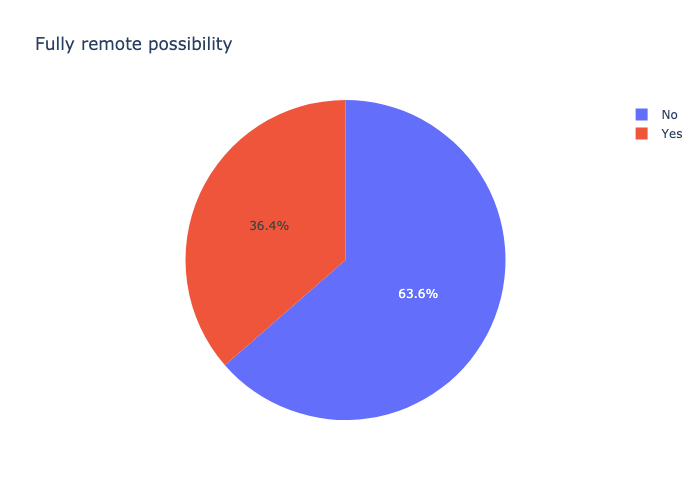

In [54]:
remote_df = prep_df['remote'].replace({True: 'Yes', False: 'No'})
fig = px.pie(remote_df, names='remote', title='Fully remote possibility')
fig

It seems that remote work has become a standard as an option.

### Categories and technologies pie charts 

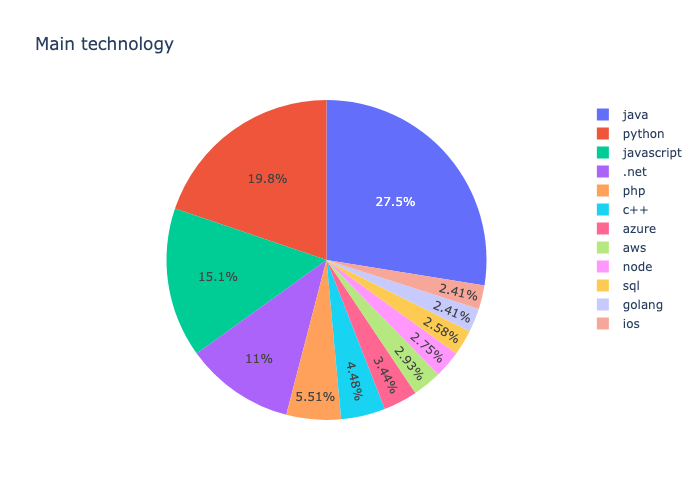

In [55]:
N_MOST_FREQ = 12

tech_most_freq_df = get_rows_with_n_most_frequent_vals_in_col(prep_df, 'technology', N_MOST_FREQ)
fig = px.pie(tech_most_freq_df, names='technology', title='Main technology')
fig

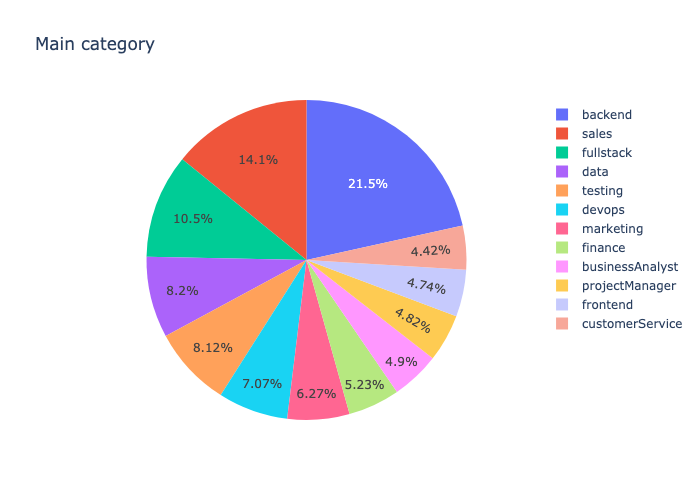

In [56]:
N_MOST_FREQ = 12

cat_largest_df = get_rows_with_n_most_frequent_vals_in_col(prep_df, 'category', N_MOST_FREQ)
fig = px.pie(cat_largest_df, names='category', title='Main category')
fig

### Seniority

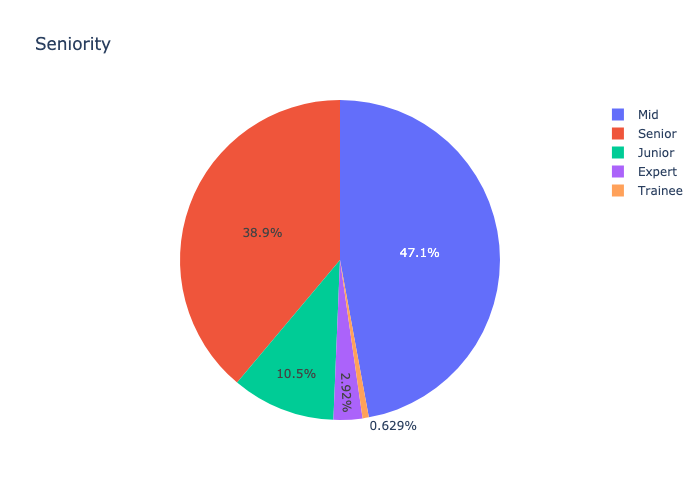

In [57]:
seniorities_df = prep_df.explode('seniority')
fig = px.pie(seniorities_df, names='seniority', title='Seniority')
fig

### Categories and technologies Sankey chart 

Let's draw a graph that will help us to understand relations between technologies and job categories.

In [58]:
N_MOST_FREQ_CAT = 12
N_MOST_FREQ_TECH = 12
MIN_FLOW = 12

cat_most_freq = get_n_most_frequent_vals_in_col(prep_df['category'], N_MOST_FREQ_CAT)
tech_most_freq = get_n_most_frequent_vals_in_col(prep_df['technology'], N_MOST_FREQ_TECH)
cat_tech_most_freq_df = prep_df[
    prep_df['category'].isin(cat_most_freq) & prep_df['technology'].isin(tech_most_freq)
]

catgrp = cat_tech_most_freq_df.groupby('category')['technology'].value_counts()
catgrp = catgrp.drop(catgrp[catgrp < MIN_FLOW].index)
catgrp = catgrp.dropna()

In [59]:
catgrp_list = catgrp.index.to_list()
sources = [el[0] for el in catgrp_list]
targets = [el[1] for el in catgrp_list]
values = catgrp.to_list()

In [60]:
le = preprocessing.LabelEncoder()
le.fit(sources + targets)
sources_e = le.transform(sources)
targets_e = le.transform(targets)

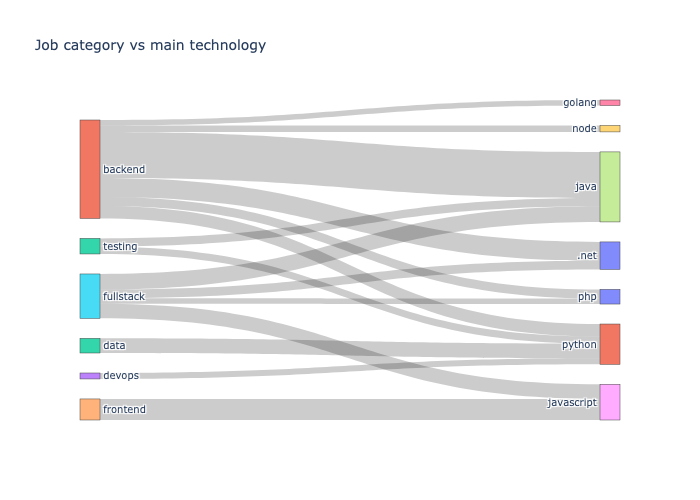

In [61]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      label = np.unique(sources + targets),
    ),
    link = dict(
      source = sources_e,
      target = targets_e,
      value = values
  ))])

fig.update_layout(title_text="Job category vs main technology", font_size=10)
fig

This type of visualization is called [*Sankey diagram*](https://en.wikipedia.org/wiki/Sankey_diagram). It can show flow of types within specific categories. In this context it explains how technologies relate to job categories. So we can see that all of frontend is done in JavaScript (which is quite obvious). Java is the main language in backend followed by .Net, Python, and PHP. Fullstack developers tend to run Java and .Net more often than Python.

### Maps

Let's use location data and plot job opportunities on maps.

In [62]:
cities_df = prep_df.explode('city').dropna(subset=['city'])
cities_df[['city', 'lat', 'lon']] = cities_df['city'].transform(lambda city: pd.Series([city[0], city[1], city[2]]))

In [63]:
def make_map(postings_df: pd.DataFrame, title: str, min_city_freq=10):
    POLAND_LAT, POLAND_LON = 52.0, 19.0

    job_counts = postings_df.groupby('city')['id'].count()
    salaries = postings_df.groupby('city')[['salary_mean', 'lat', 'lon']].mean()
    cities_salaries = pd.concat([job_counts.rename('job_counts'), salaries], axis=1)
    more_than_min = cities_salaries['job_counts'] > min_city_freq
    cities_salaries = cities_salaries[more_than_min]
    cities_salaries = cities_salaries.reset_index()

    fig = px.scatter_geo(
        cities_salaries,
        lat='lat',
        lon='lon',
        size='job_counts',
        color='salary_mean',
        title=title,
        labels={'salary_mean': 'Mean salary', 'job_counts': 'Number of jobs'},
        hover_data={'city': True, 'lat': False, 'lon': False},
    )

    fig.update_layout(
        geo=dict(
            scope='europe',
            center={'lat': POLAND_LAT, 'lon': POLAND_LON},
            projection_scale=10,
        )
    )

    return fig

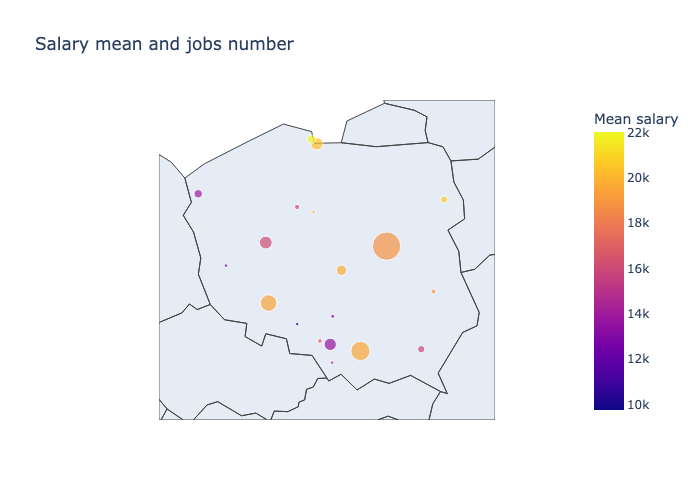

In [64]:
make_map(cities_df, 'Salary mean and jobs number')

It seems a bit counterintuitive that some small cities offer better salaries than the capital. Let's break down this map by seniority to get better insights.

In [65]:
seniority_cities_df = cities_df.explode('seniority')

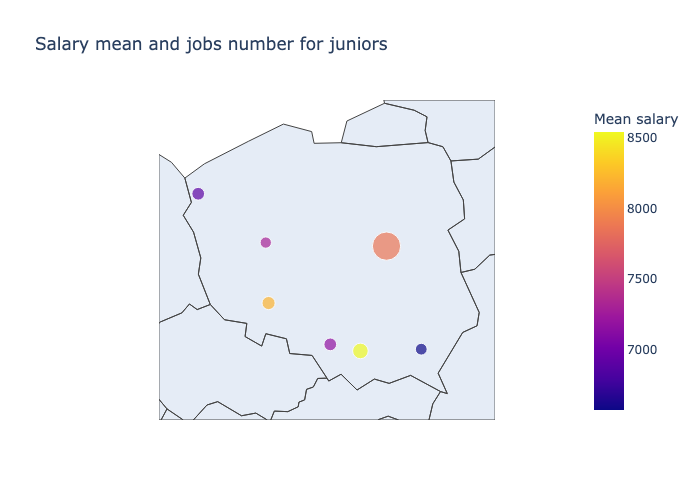

In [66]:
seniority_cities_junior_df = seniority_cities_df[seniority_cities_df['seniority'] == 'Junior']
make_map(seniority_cities_junior_df, 'Salary mean and jobs number for juniors')

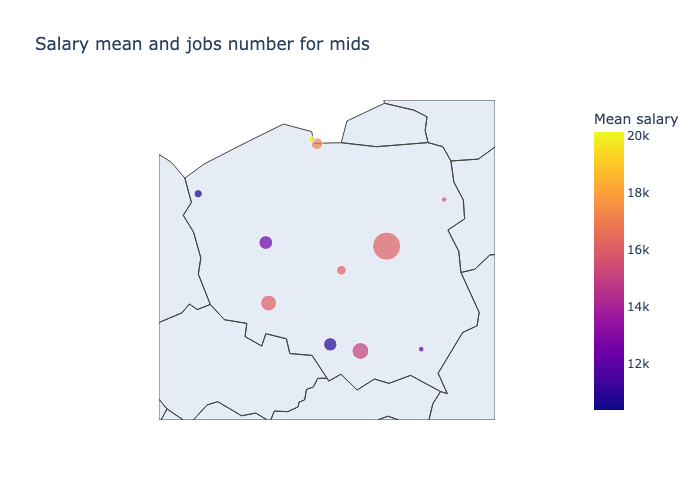

In [67]:
seniority_cities_mid_df = seniority_cities_df[seniority_cities_df['seniority'] == 'Mid']
make_map(seniority_cities_mid_df, 'Salary mean and jobs number for mids')

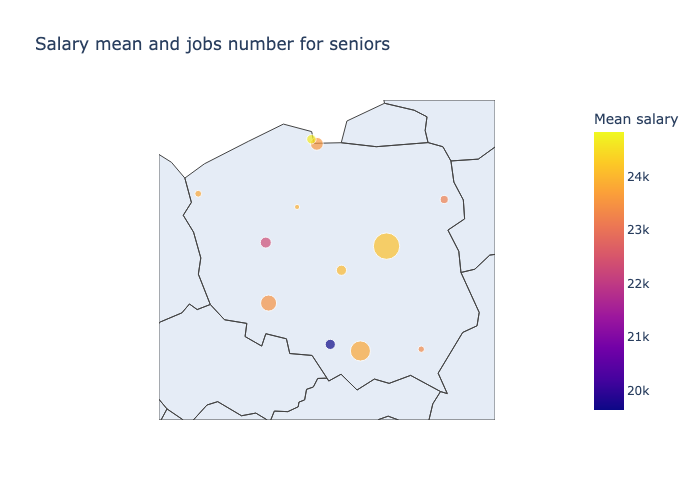

In [68]:
seniority_cities_senior_df = seniority_cities_df[seniority_cities_df['seniority'] == 'Senior']
make_map(seniority_cities_senior_df, 'Salary mean and jobs number for seniors')

It looks like small towns offer fewer entry level jobs. That is why they scored so high in the first map. If we analyse the salaries with regard to seniority it becomes clear that big cities offer better payments and more jobs for beginners.

### Salaries histogram 

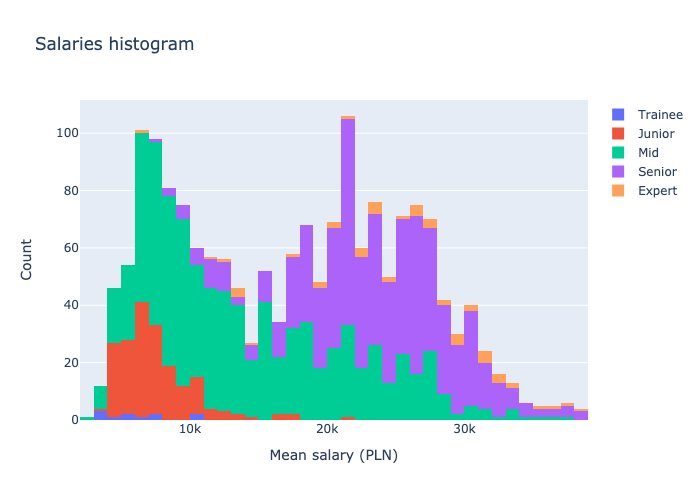

In [69]:
MAX_SALARY = 40000

seniorities_df = prep_df.explode('seniority')
limited = seniorities_df[seniorities_df['salary_mean'] < MAX_SALARY]
limited = limited[limited['salary_mean'] > 0]
limited = sort_by_seniority(limited)

fig = px.histogram(limited, x='salary_mean', color='seniority', title='Salaries histogram')
fig = fig.update_layout(
    legend_title_text=None,
    xaxis_title_text='Mean salary (PLN)',
    yaxis_title_text='Count',
)
fig

### Violin plots

Let's explore salaries distributions in greater detail.

#### Salaries violin plot split by technology

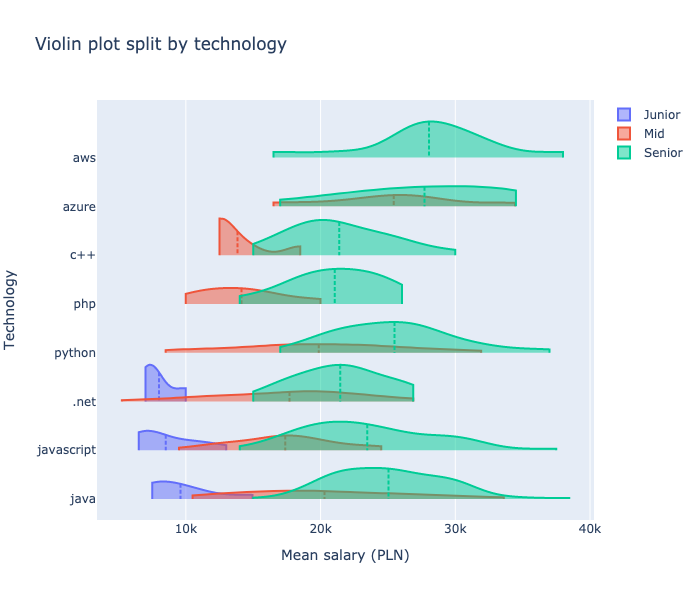

In [70]:
MAX_SALARY = 40000
N_MOST_FREQ_TECH = 8

seniorities_df = prep_df.explode('seniority')
tech_most_freq = get_rows_with_n_most_frequent_vals_in_col(seniorities_df, 'technology', N_MOST_FREQ_TECH)
limited = tech_most_freq[tech_most_freq['salary_mean'] < MAX_SALARY]
limited = limited[limited['seniority'].isin(('Junior', 'Mid', 'Senior'))]
limited = sort_by_seniority(limited)

limited = limited.groupby(['seniority', 'technology']).filter(
    lambda x: x['technology'].count() > 3
)

limited = limited[limited['salary_mean'] > 100]

fig = px.violin(
    limited,
    x='salary_mean',
    y='technology',
    color='seniority',
    violinmode='overlay',
    title='Violin plot split by technology',
    points=False,
)
fig = fig.update_traces(side='positive', width=1.5, spanmode='hard', meanline_visible=True)
fig = fig.update_layout(
    height=600,
    xaxis_title_text='Mean salary (PLN)',
    yaxis_title_text='Technology',
    legend_title_text=None,
)
fig

#### Salaries violin plot split by contract type

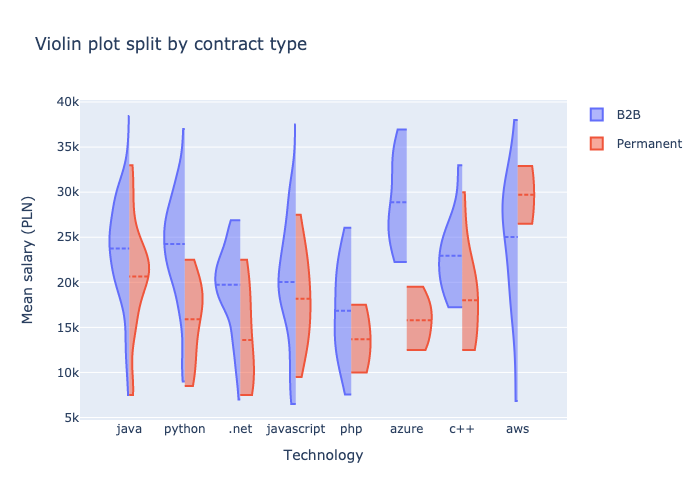

In [71]:
MAX_SALARY = 40000
N_MOST_FREQ_TECH = 8

tech_most_freq = get_rows_with_n_most_frequent_vals_in_col(prep_df, 'technology', N_MOST_FREQ_TECH)
limited = tech_most_freq[tech_most_freq['salary_mean'] < MAX_SALARY]
b2b_df = limited[limited['contract_type'] == 'b2b']
perm_df = limited[limited['contract_type'] == 'permanent']

fig = go.Figure()
fig.add_trace(
    go.Violin(
        x=b2b_df['technology'],
        y=b2b_df['salary_mean'],
        legendgroup='B2B',
        scalegroup='B2B',
        name='B2B',
        side='negative',
        spanmode='hard',
        points=False,
    )
)
fig.add_trace(
    go.Violin(
        x=perm_df['technology'],
        y=perm_df['salary_mean'],
        legendgroup='Permanent',
        scalegroup='Permanent',
        name='Permanent',
        side='positive',
        spanmode='hard',
        points=False,
    )
)
fig.update_traces(meanline_visible=True, width=0.9)
fig.update_layout(
    violingap=0,
    violinmode='overlay',
    yaxis_title_text='Mean salary (PLN)',
    xaxis_title_text='Technology',
    title='Violin plot split by contract type',
)
fig 